In [1]:
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import cv2
from cv2 import aruco
import matplotlib.pyplot as plt
import os
import polars as pl
import toml
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.pd_support import *

from datetime import datetime
from support.pd_support import *
from support.ar_calculations import *

import toml

import plotly.io as pio
from tqdm import tqdm
import seaborn as sns

pio.renderers.default = "vscode"

In [2]:
_name = "speed_4"

_base_dir = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), "..")),
    "recorded_data",
    "five_marker_validation",
)
_data_pth = os.path.join(_base_dir, _name)
_video_binary_file = os.path.join(_data_pth, "webcam_color.msgpack")
_video_timestamp_file = os.path.join(_data_pth, "webcam_timestamp.msgpack")

settings = toml.load("calibration.toml")
_webcam_cam_mat = np.array(settings["calibration"]["camera_matrix"]).reshape((3, 3))
_webcam_dist = np.array(settings["calibration"]["dist_coeffs"]).reshape((1, 5))

MOCAP data

In [3]:
m1 = get_rb_marker_name(2)
m4 = get_rb_marker_name(4)
m3 = get_rb_marker_name(3)
m5 = get_rb_marker_name(5)

In [4]:
ts_pth = os.path.join(_video_timestamp_file)
with open(ts_pth, "rb") as ts_file:
    ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
    ts = list(ts_unpacker)

_time = np.array(ts)[:, 1]
_time = [datetime.strptime(_t, "%Y-%m-%d %H:%M:%S.%f") for _t in _time]
_sync = np.array(ts)[:, 0].astype(bool)


for idx, _s in enumerate(_sync):
    if _s:
        sync_start_idx = idx
        break

_sync_index = _sync[sync_start_idx:]

for idx, _s in enumerate(_sync_index):
    if not _s:
        sync_end_idx = idx
        break

sync_end_idx = sync_start_idx + sync_end_idx

sync_start_time = _time[sync_start_idx]
sync_end_time = _time[sync_end_idx]

In [5]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

In [6]:
def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(
            marker_points, c, mtx, distortion, True, flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()

        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [7]:
_video = open(_video_binary_file, "rb")
_video_file = mp.Unpacker(_video, object_hook=mpn.decode)
corners_data = list(_video_file)
shape = corners_data[0]

data = {"frame_id": [], "marker_ids": [], "corners": [], "tvec": [], "rvec": []}
counter = 0

for _frame in tqdm(corners_data[1:]):
    corners, ids = _frame

    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        rvec, tvec = estimatePoseSingleMarkers(
            corners=corners,
            marker_size=0.05,
            mtx=_webcam_cam_mat,
            distortion=_webcam_dist,
        )
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(tvec)
        data["rvec"].append(rvec)
    counter += 1

100%|██████████| 5797/5797 [00:00<00:00, 6133.97it/s]


In [8]:
default_ids = [12, 14, 20, 88, 89]
coordinate = {
    str(id): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []}
    for id in default_ids
}

for i, frame_id in enumerate(data["frame_id"]):
    if data["marker_ids"][i] is not None:
        existing_ids = set(data["marker_ids"][i].reshape(-1))
        missing_ids = set(default_ids) - existing_ids

        for _m, tvec, rvec in zip(
            data["marker_ids"][i], data["tvec"][i], data["rvec"][i]
        ):
            if _m in default_ids:
                coord = coordinate[str(_m[0])]
                coord["x"].append(tvec[0][0])
                coord["y"].append(tvec[0][1])
                coord["z"].append(tvec[0][2])
                coord["rx"].append(rvec[0][0])
                coord["ry"].append(rvec[0][1])
                coord["rz"].append(rvec[0][2])

        for _m in missing_ids:
            coord = coordinate[str(_m)]
            coord["x"].append(np.nan)
            coord["y"].append(np.nan)
            coord["z"].append(np.nan)
            coord["rx"].append(np.nan)
            coord["ry"].append(np.nan)
            coord["rz"].append(np.nan)
    else:
        for _m in default_ids:
            coord = coordinate[str(_m)]
            coord["x"].append(np.nan)
            coord["y"].append(np.nan)
            coord["z"].append(np.nan)
            coord["rx"].append(np.nan)
            coord["ry"].append(np.nan)
            coord["rz"].append(np.nan)

AR coordinate transformation

In [9]:
ar_df = pl.from_dicts(coordinate["89"])
rvec = ar_df[["rx", "ry", "rz"]][0].to_numpy()
ar_rotmat = cv2.Rodrigues(rvec)[0]

tar = ar_rotmat.T @ (
    ar_df[["x", "y", "z"]].to_numpy().T - ar_df[["x", "y", "z"]][0].to_numpy().T
)
_ar_df = pl.from_dicts({"time": _time, "x": tar[0], "y": tar[1], "z": tar[2]})

Reading mocap data

In [10]:
_mocap_path = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), "..")),
    "recorded_data",
    "five_marker_validation",
    "mocap",
    f"{_name}.csv",
)
_mocap_df, st_time = read_rigid_body_csv(_mocap_path)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
_mocap_df = pl.from_pandas(_mocap_df)

cumulative = (
    _mocap_df[[m1["x"], m1["y"], m1["z"]]].to_numpy().T
    + _mocap_df[[m4["x"], m4["y"], m4["z"]]].to_numpy().T
    + _mocap_df[[m3["x"], m3["y"], m3["z"]]].to_numpy().T
    + _mocap_df[[m5["x"], m5["y"], m5["z"]]].to_numpy().T
)
cumulative = cumulative / 4

_m_df = pl.DataFrame(
    {
        "time": _mocap_df["time"],
        "x": cumulative[0],
        "y": cumulative[1],
        "z": cumulative[2],
    }
)

e:\CMC\pyprojects\DeepVision\wearable\..\support\pd_support.py:326: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



MoCap transformation

In [11]:
_mc_org = _mocap_df[[m3["x"], m3["y"], m3["z"]]][0].to_numpy().T
_mc_xvec = _mocap_df[[m5["x"], m5["y"], m5["z"]]][0].to_numpy().T
_mc_yvec = _mocap_df[[m1["x"], m1["y"], m1["z"]]][0].to_numpy().T

_mc_rotmat = calculate_rotmat_from_xyo(_mc_xvec, _mc_yvec, _mc_org)

tmc = _mc_rotmat.T @ (
    _m_df[["x", "y", "z"]].to_numpy().T - _m_df[["x", "y", "z"]][0].to_numpy().T
)
_mc_df = pl.DataFrame(
    {"time": _mocap_df["time"], "x": tmc[0], "y": tmc[1], "z": tmc[2]}
)

In [12]:
velocity_cuts = np.nanmax(abs(_mc_df["x"].diff() / 0.01)) / 12
_vel_bins = []
for i in range(12):
    _vel_bins.append((i) * velocity_cuts)

In [13]:
_vel_bins

[0.0,
 0.12239799721367767,
 0.24479599442735533,
 0.367193991641033,
 0.48959198885471067,
 0.6119899860683884,
 0.734387983282066,
 0.8567859804957436,
 0.9791839777094213,
 1.101581974923099,
 1.2239799721367768,
 1.3463779693504543]

In [14]:
bin_idx = np.digitize(abs(_mc_df["x"].diff() / 0.01), bins=_vel_bins, right=True)
bin_df = pl.Series("bin", bin_idx)
_mc_df.insert_column(4, bin_df)
_mc_df.group_by("bin", maintain_order=True).count()

C:\Users\Pintu\AppData\Local\Temp\ipykernel_65452\3758313044.py:4: DeprecationWarning:

`GroupBy.count` is deprecated. It has been renamed to `len`.



bin,count
i64,u32
12,30
1,1622
2,615
3,691
4,861
…,…
7,622
8,630
9,478


Correct time offset in AR

In [15]:
ar_df = ar_df.insert_column(0, pl.Series("time", _time))
ar_df = ar_df[sync_start_idx:sync_end_idx]

In [16]:
_data_time_offset = sync_start_time - _mocap_df["time"][0]
# ar_df = ar_df[sync_start_time:sync_end_time]

_mc_df = _mc_df.with_columns([(pl.col("time") + _data_time_offset).alias("time")])
# _ar_df_test = ar_df.with_columns([(pl.col('time') - _data_time_offset).alias('time')])
# _ar_df = _ar_df_test

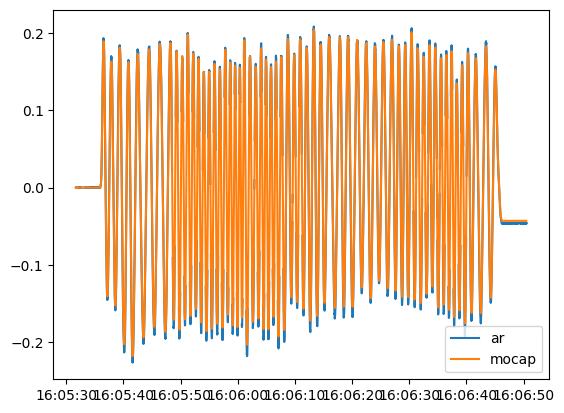

In [17]:
plt.plot(ar_df["time"], -(ar_df["x"] - ar_df["x"][0]), label="ar")
plt.plot(_mc_df["time"], _mc_df["x"] - _mc_df["x"][0], label="mocap")

plt.legend()

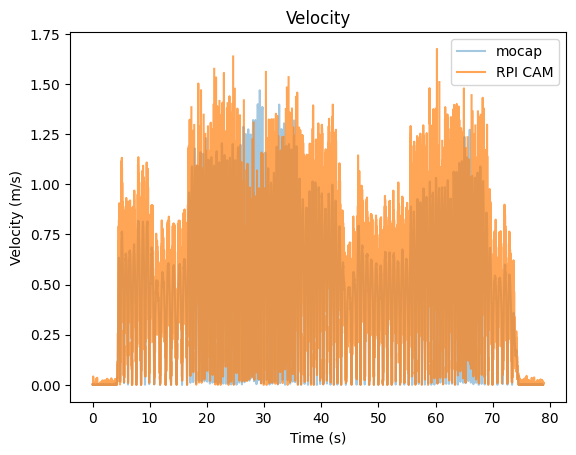

In [18]:
ar_time = ar_df["time"].dt.epoch()
ar_time = ar_time - ar_time[0]
ar_time = [timedelta(microseconds=t).total_seconds() for t in ar_time]
ar_time = np.array(ar_time)

mc_time = _mocap_df["time"].dt.epoch()
mc_time = mc_time - mc_time[0]
mc_time = [timedelta(microseconds=t).total_seconds() for t in mc_time]
mc_time = np.array(mc_time)

ar_del_t = np.nanmean(_ar_df["time"].dt.epoch().diff().to_numpy() / 10**6)
mc_del_t = 0.01

plt.plot(mc_time, abs(_mc_df["x"].diff()) / mc_del_t, label="mocap", alpha=0.4)
plt.plot(ar_time, abs(ar_df["x"].diff()) / ar_del_t, alpha=0.7, label="RPI CAM")
plt.title("Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()

Interpolating dfs

In [19]:
f = interp1d(
    _mc_df["time"].dt.epoch(), _mc_df["x"], kind="linear", fill_value="extrapolate"
)  # You can also use 'cubic' or other interpolation methods
_mc_x = f(_ar_df["time"].dt.epoch())
_mc_xdf = pl.DataFrame({"time": _ar_df["time"], "x": _mc_x})

In [20]:
# plt.plot(
#     ar_time, abs(_mc_xdf["x"][: len(_mc_x)].diff()) / ar_del_t, label="mocap", alpha=0.4
# )
# plt.plot(ar_time, abs(_ar_df["x"].diff()) / ar_del_t, alpha=0.9, label="ar")
# plt.title("Velocity")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.legend()

In [21]:
_vel_bins

[0.0,
 0.12239799721367767,
 0.24479599442735533,
 0.367193991641033,
 0.48959198885471067,
 0.6119899860683884,
 0.734387983282066,
 0.8567859804957436,
 0.9791839777094213,
 1.101581974923099,
 1.2239799721367768,
 1.3463779693504543]

In [22]:
bin_idx = np.digitize(abs(_mc_xdf["x"].diff() / ar_del_t), bins=_vel_bins, right=True)
bin_df = pl.Series("bin", bin_idx)
_mc_xdf.insert_column(2, bin_df)
_mc_xdf.group_by("bin", maintain_order=True)

In [23]:
len(_vel_bins)

12

In [24]:
bins_idx = {
    "1": [],
    "2": [],
    "3": [],
    "4": [],
    "5": [],
    "6": [],
    "7": [],
    "8": [],
    "9": [],
    "10": [],
    "11": [],
    "12": [],
}
for idx, i in enumerate(_mc_xdf["bin"]):
    if i == 1:
        bins_idx["1"].append(idx)
    elif i == 2:
        bins_idx["2"].append(idx)
    elif i == 3:
        bins_idx["3"].append(idx)
    elif i == 4:
        bins_idx["4"].append(idx)
    elif i == 5:
        bins_idx["5"].append(idx)
    elif i == 6:
        bins_idx["6"].append(idx)
    elif i == 7:
        bins_idx["7"].append(idx)
    elif i == 8:
        bins_idx["8"].append(idx)
    elif i == 9:
        bins_idx["9"].append(idx)
    elif i == 10:
        bins_idx["10"].append(idx)
    elif i == 11:
        bins_idx["11"].append(idx)
    elif i == 12:
        bins_idx["12"].append(idx)

In [25]:
_mc_1 = abs(_mc_xdf["x"].diff() / ar_del_t).drop_nans()[1:] / np.nanmax(
    abs(_mc_xdf["x"].diff() / ar_del_t).drop_nans()[1:]
)
_ar_1 = abs(_ar_df["x"].diff() / ar_del_t).drop_nans()[1:] / np.nanmax(
    abs(_ar_df["x"].diff() / ar_del_t).drop_nans()[1:]
)

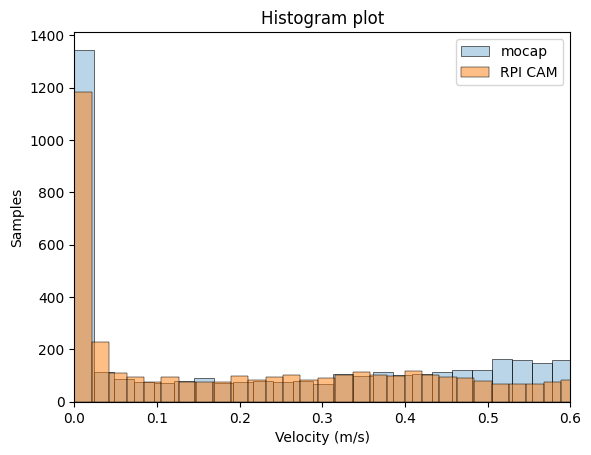

In [26]:
sns.histplot(abs(_mc_xdf["x"].diff() / ar_del_t), bins=80, label="mocap", alpha=0.3)
sns.histplot(abs(_ar_df["x"].diff()) / (ar_del_t), bins=80, alpha=0.5, label="RPI CAM")
plt.xlim(0, 0.6)
plt.title("Histogram plot")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Samples")
plt.legend()

In [28]:
# fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(16, 5))
# ax0.plot(
#     ar_time, abs(_mc_xdf["x"].diff()) / ar_del_t, label="mocap", alpha=0.4
# )
# ax0.plot(ar_time, abs(_ar_df["x"].diff()) / ar_del_t, alpha=0.9, label="ar")
# ax0.set_title("Velocity")
# ax0.set_xlabel("Time (s)")
# ax0.set_ylabel("Velocity (m/s)")
# ax0.legend()

# sns.histplot(
#     abs(_mc_xdf["x"].diff() / ar_del_t),
#     bins=100,
#     label="mocap",
#     alpha=0.3,
#     ax=ax1,
#     stat="probability",
# )
# sns.histplot(
#     abs(_ar_df["x"].diff()) / ar_del_t,
#     bins=100,
#     alpha=0.5,
#     label="ar",
#     ax=ax1,
#     stat="probability",
# )
# ax1.set_title("Histogram plot")
# ax1.set_xlabel("Velocity")
# ax1.set_ylabel("Samples")
# ax1.set_xlim(0, 0.6)
# ax1.legend()

In [29]:
bin_numbers = ["1", "2", "3", "4", "5", "6", "7"]
missing_percentage = []
for i in bin_numbers:
    missing_percentage.append(
        _ar_df["x"][bins_idx[i]].is_nan().sum() / len(_ar_df["x"][bins_idx[i]])
    )

Percentage of missing data

In [30]:
100 - np.array(missing_percentage) * 100

array([100.        , 100.        , 100.        , 100.        ,
       100.        ,  99.80916031,  96.70886076])

Text(0.5, 1.0, 'Percentage of detection RPI camera')

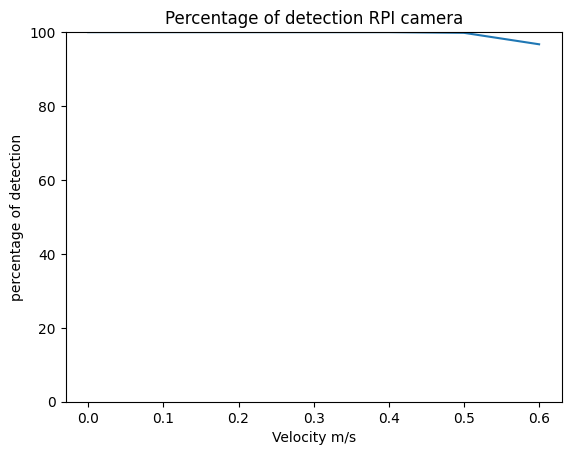

In [31]:
plt.plot(np.arange(0, 0.7, 0.1), 100 - np.array(missing_percentage) * 100)
plt.ylim(0, 100)
plt.ylabel("percentage of detection")
plt.xlabel("Velocity m/s")
plt.title("Percentage of detection RPI camera")

In [35]:
a1 = [100.0, 100.0, 100.0, 100.0, 100.0, 99.65034965, 99.11764706]
a2 = [100.0, 100.0, 100.0, 100.0, 100.0, 99.63768116, 98.87955182]
a3 = [100.0, 100.0, 100.0, 100.0, 100.0, 99.80916031, 96.70886076]
a4 = np.array([a1, a2, a3])

In [57]:
import polars as pl

df = pl.from_dict(
    {
        "0.0": a4.T[0],
        "0.1": a4.T[1],
        "0.2": a4.T[2],
        "0.3": a4.T[3],
        "0.4": a4.T[4],
        "0.5": a4.T[5],
        "0.6": a4.T[6],
    }
)

In [69]:
sns.boxplot(
    x=df.columns,
    data=df,
    showfliers=False,
)
plt.ylim([95, 101])
plt.xlabel("10 cm / s")
plt.ylabel("Percentage of detection (%)")
plt.title("Percentage of detection (%)")

ValueError: Length of list vectors must match length of `data` when both are used, but `data` has length 3 and the vector passed to `x` has length 7.